In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("../")
import warnings
warnings.filterwarnings("ignore")

In [2]:
import json
import glob
from tqdm.notebook import trange, tqdm
import numpy as np
import pandas as pd
from features import prepare_entry, get_transformer, merge_entries
from utills import chunker, compress_fraction
import pickle
from matplotlib import rcParams
import matplotlib.pyplot as plt
import matplotlib.style as style
from pushshift_api import get_user_comments
from datetime import datetime
%matplotlib inline

import networkx as nx
from plotly.offline import init_notebook_mode
import plotly.offline as py
import plotly.graph_objs as go
init_notebook_mode(connected=True)

In [3]:
from config import known_bots

In [4]:
tqdm.pandas()

In [5]:
DATA_DIR = '../data/'
TEMP_DIR = '../temp_data/'
# DATA_PATH = DATA_DIR + 'gamestop/comments.jsonl'
DATA_PATH = DATA_DIR + 'sockpuppets/r_funny/comments.jsonl'
TEMP_DATA_PATH = TEMP_DIR + 'sockpuppets/r_funny/'
MULTIDOC_MODEL_PATH = TEMP_DIR + 'reddit/multidoc_20/model_20.p'
SINGLEDOC_MODEL_PATH = TEMP_DIR + 'reddit/unchunked/model.p'
chunk_sz = 20

Load Predictions From HPC
===

In [6]:
with open(TEMP_DATA_PATH + 'vectorizing_parameters.p', 'rb') as f:
    (author_order, total_chunks, author_bounds, author_to_idx_nc, x_shape, x_shape_nc) = pickle.load(f)
len(author_bounds)

1558

In [7]:
result_files = [TEMP_DATA_PATH + 'predict_results_instance_' + str(i) + '.p' for i in range(5)]

In [8]:
user_pairs = []
probs_nc = []

inter_probs_mean = []
inter_probs_std = []

intraA_probs_mean = []
intraA_probs_std = []

intraB_probs_mean = []
intraB_probs_std = []
pred_lengths = []
    
for fp in tqdm(result_files):
    with open(fp, 'rb') as f:
        try:
            (
                local_probs_nc,
                local_inter_probs_mean,
                local_inter_probs_std,
                local_intraA_probs_mean,
                local_intraA_probs_std,
                local_intraB_probs_mean,
                local_intraB_probs_std,
                local_pred_lengths,
                _, 
                local_user_pairs
            ) = pickle.load(f)
            
            probs_nc.extend(local_probs_nc)
            inter_probs_mean.extend(local_inter_probs_mean)
            inter_probs_std.extend(local_inter_probs_std)
            intraA_probs_mean.extend(local_intraA_probs_mean)
            intraA_probs_std.extend(local_intraA_probs_std)
            intraB_probs_mean.extend(local_intraB_probs_mean)
            intraB_probs_std.extend(local_intraB_probs_std)
            pred_lengths.extend(local_pred_lengths)
            user_pairs.extend(local_user_pairs)
        except:
            continue

In [9]:
user_pairs = np.array(user_pairs)

In [9]:
len(user_pairs)

1212900

In [10]:
inter_probs_mean = np.array(inter_probs_mean)
intraA_probs_mean = np.array(intraA_probs_mean)
intraB_probs_mean = np.array(intraB_probs_mean)
inter_probs_std = np.array(inter_probs_std)
intraA_probs_std = np.array(intraA_probs_std)
intraB_probs_std = np.array(intraB_probs_std)
pred_lengths = np.array(pred_lengths)


probs_nc = np.array(probs_nc)

n_a = pred_lengths[:, 0]
n_b = pred_lengths[:, 1]
n_ab = pred_lengths[:, 2]

intra_probs_mean = (intraA_probs_mean * n_a + intraB_probs_mean * n_b)/ (n_a + n_b)
intra_probs_std = (
        n_a * (intraA_probs_std ** 2 + (intraA_probs_mean - intra_probs_mean)**2) + 
        n_b * (intraB_probs_std ** 2 + (intraB_probs_mean - intra_probs_mean)**2)
    ) / (n_a + n_b)


pooled_mean = (intra_probs_mean * (n_a + n_b) + inter_probs_mean * n_ab)/ (n_a + n_b + n_ab)
pooled_std = (
        (n_a + n_b) * (intra_probs_mean ** 2 + (intra_probs_mean - pooled_mean)**2) + 
        n_ab * (inter_probs_mean ** 2 + (inter_probs_mean - pooled_mean)**2)
    ) / (n_a + n_b + n_ab)


In [11]:
inter_intra_sim = (1 - np.abs(inter_probs_mean - intra_probs_mean))
aggr_score = (probs_nc * (1 - np.abs(inter_probs_mean - intra_probs_mean)))

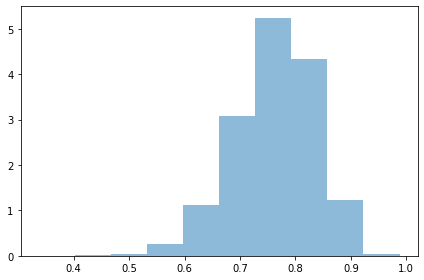

In [12]:
fig, ax = plt.subplots()

ax.hist(intra_probs_mean, alpha=0.5, density=True)


plt.tight_layout()
plt.show()

In [16]:
FIGURES_PATH = '../figures/'
TEXT_WIDTH = 7.0 # Text with on a column
HALF_COL_WIDTH = (TEXT_WIDTH - 0.5)/2
HEIGHT = 2


style.use('seaborn-whitegrid')

rcParams['font.family'] = 'serif'
rcParams['font.serif'] = [ 'Times New Roman', 'Times', 'DejaVu Serif',
 'Bitstream Vera Serif',
 'Computer Modern Roman',
 'New Century Schoolbook',
 'Century Schoolbook L',
 'Utopia',
 'ITC Bookman',
 'Bookman',
 'Nimbus Roman No9 L',
 'Palatino',
 'Charter',
 'serif']
rcParams['font.size']=9 

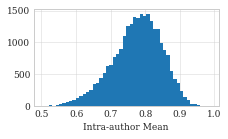

In [17]:
fig = plt.figure(figsize=(HALF_COL_WIDTH, HEIGHT))

plt.hist(intra_probs_mean, bins=50)

plt.xlabel('Intra-author Mean')
plt.grid(True, alpha=0.5)
plt.tight_layout()

plt.show()
# fig.savefig(FIGURES_PATH + 'plt_gamestop_intra_author_mean.pdf', bbox_inches='tight')

In [13]:
intra_probs_mean.mean()

0.7624597977819125

In [14]:
fig = plt.figure(figsize=(HALF_COL_WIDTH, HEIGHT))

plt.hist(aggr_score, bins=50)

plt.xlabel('Aggregated Score')
plt.grid(True, alpha=0.5)
plt.tight_layout()

plt.show()
# fig.savefig(FIGURES_PATH + 'plt_gamestop_aggre_score.pdf', bbox_inches='tight')

NameError: name 'HALF_COL_WIDTH' is not defined

In [15]:
selected_mask = aggr_score > 0.995

In [19]:
sockpuppet_users = np.unique(user_pairs[aggr_score > 0.995].flatten())
len(sockpuppet_users), len(sockpuppet_users)/len(author_bounds), len(user_pairs[aggr_score > 0.995])

(17, 0.010911424903722721, 9)